In [1]:
import glob, os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

mkdir: ../jupyter_figures: File exists


In [2]:
def is_on_edge(cnt, width=1024, height=1024, tolerance=1, im=None):
    '''
    Determine whether a contour (cnt) is on the edge of image (im)
    
    Input Parameters:
    -----------------
    cnt:
        contour of an object (outline)
        
    width, height:
        image width and height in pixels
        
    tolerance:
        distance from the edge to be called on_edge; in pixels
        default: 1
        
    im: 
        numpy array of image read by opencv; if provided, calculate the width and height
    
    
    Returns:
    --------
    res:
        boolean value of whether cnt is on the edge of im
    
    '''
    if im is not None:
        height, width = im.shape
    
    # Get bounding rectangle of the coutour
    x,y,w,h = cv.boundingRect(cnt)
    if (x<=tolerance) or (y<=tolerance) or (x+w>=width-tolerance) or (y+h>=height-tolerance):
        res = True
    else:
        res = False
    
    return res


def get_shape_metrics(outlines_file, width=1024, height=1024, tolerance=1):
    '''
    Compute shape metrics from a txt file storing object outlines
    
    Input Parameters:
    -----------------
    outlines_file:
        A txt file, each line of which has a series of numbers representing
        the (x, y) coordinates
        
    width, height:
        Original image width and height in pixels; used to determine whether
        the object is on_edge
        
    tolerance:
        distance from the edge to be called on_edge; in pixels
        default: 1
    
    
    Returns:
    --------
    df:
        A pandas dataframe with the following columns:
        'cell_id', 'centroid_x', 'centroid_y',
        'area', 'perimeter', 'on_edge',
        'circularity', 'aspect_ratio', 'solidity', 'file_name'
        
    '''
    # Read in coordinates from the outlines text file
    with open(outlines_file, 'r') as f:
        lines = f.readlines()

    shape_metrics = []
    for i, line in enumerate(lines):
        # parse numbers representing (x, y) coordinates
        coordinates = [int(num) for num in line.strip().split(',')]

        # Reshape 1D to 2D
        cnt = np.reshape(coordinates, (-1, 2))

        # compute image moments
        M = cv.moments(cnt)

        # compute centroids from moments
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        # compute area
        area = cv.contourArea(cnt)

        # compute perimeter
        # second parameter is to specify whether contour is closed
        perimeter = cv.arcLength(cnt,True)

        # compute circularity defined as: 4pi*area/sqr(perimeter)
        circularity = 4*np.pi*area/perimeter/perimeter

        # fit ellipse to obtain major and min axis to 
        # compute apsect ratio and angle
        (x,y),(ma,MA),angle = cv.fitEllipse(cnt)
        aspect_ratio = MA/ma

        # compute the convex hull to compute solidity
        hull = cv.convexHull(cnt)
        hull_area = cv.contourArea(hull)
        solidity = float(area)/hull_area

        # determine whether the object is on the image edge
        on_edge = is_on_edge(cnt)

        temp_metrics = [i+1, cx, cy, area, perimeter, on_edge,
                        circularity, aspect_ratio, solidity]
        shape_metrics.append(temp_metrics)

    df = pd.DataFrame(shape_metrics, columns=['cell_id', 'centroid_x', 'centroid_y',
                                              'area', 'perimeter', 'on_edge',
                                              'circularity', 'aspect_ratio', 'solidity'])
 
    base_file_name = os.path.basename(outlines_file)
    df['file_name'] = [base_file_name]*len(df)
    
    return df

In [3]:
collagenase_outline_files = glob.glob('../data/SMG-mesenchyme-images/*collagenase*outlines.txt')
collagenase_outline_files.sort()
collagenase_outline_files

['../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-001-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-002-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-003-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-004-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-005-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-collagenase-F-actin-60x-006-mesenchyme_cp_outlines.txt']

In [4]:
control_outline_files = glob.glob('../data/SMG-mesenchyme-images/*control*outlines.txt')
control_outline_files.sort()
control_outline_files

['../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-001-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-002-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-003-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-004-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-005-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-006-mesenchyme_cp_outlines.txt',
 '../data/SMG-mesenchyme-images/210220-SMG-control-F-actin-60x-007-mesenchyme_cp_outlines.txt']

In [5]:
dfs_collagenase = [get_shape_metrics(f) for f in collagenase_outline_files]
df_collagenase = pd.concat(dfs_collagenase)
df_collagenase.reset_index(inplace=True, drop=True)
df_collagenase['groups'] = ['collagenase']*len(df_collagenase)

In [6]:
dfs_control = [get_shape_metrics(f) for f in control_outline_files]
df_control = pd.concat(dfs_control)
df_control.reset_index(inplace=True, drop=True)
df_control['groups'] = ['control']*len(df_control)

In [7]:
df = pd.concat([df_control, df_collagenase])
df.reset_index(inplace=True, drop=True)

In [8]:
# Convert area (cell size) unit from square pixels to 100 square microns
# 4.8272 pixels per micron => Pixel size: 0.20716 microns/pixel

pixel_size = 0.20716 # microns/pixel
df['area_100_sq_microns'] = df.area*pixel_size*pixel_size/100

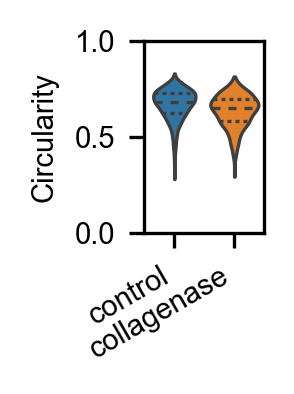

In [9]:
output_prefix = '210220-SMG-collagenase-F-actin-60x'
output_file_name = '../jupyter_figures/' + output_prefix + '-circularity.svg'

fig = plt.figure(figsize=(0.5, 0.8), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='groups', y='circularity', data=df, inner='quartile',
               scale= 'count', cut=0, linewidth=.8)

# Remove excessive clipping
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")
    
plt.xlabel(None)
plt.ylabel('Circularity')
plt.yticks([0, 0.5, 1])

plt.savefig(output_file_name)


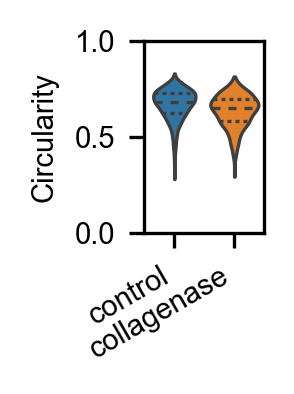

In [10]:
output_prefix = '210220-SMG-collagenase-F-actin-60x'
output_file_name = '../jupyter_figures/' + output_prefix + '-circularity.svg'

fig = plt.figure(figsize=(0.5, 0.8), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='groups', y='circularity', data=df, inner='quartile',
               scale= 'count', cut=0, linewidth=.8)

# Remove excessive clipping
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")
    
plt.xlabel(None)
plt.ylabel('Circularity')
plt.yticks([0, 0.5, 1])

plt.savefig(output_file_name)


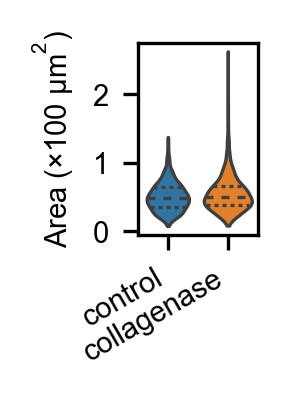

In [11]:
output_prefix = '210220-SMG-collagenase-F-actin-60x'
output_file_name = '../jupyter_figures/' + output_prefix + '-area.svg'

fig = plt.figure(figsize=(0.5, 0.8), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='groups', y='area_100_sq_microns', data=df, inner='quartile',
               scale= 'count', cut=0, linewidth=.8)

# Remove excessive clipping
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")
    
plt.xlabel(None)
plt.ylabel('Area (×100 $\mathregular{µm^2}$)')
# plt.yticks([0, 0.5, 1])

plt.savefig(output_file_name)


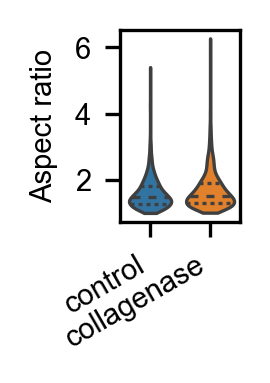

In [12]:
output_prefix = '210220-SMG-collagenase-F-actin-60x'
output_file_name = '../jupyter_figures/' + output_prefix + '-aspect_ratio.svg'

fig = plt.figure(figsize=(0.5, 0.8), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='groups', y='aspect_ratio', data=df, inner='quartile',
               scale= 'count', cut=0, linewidth=.8)

# Remove excessive clipping
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")
    
plt.xlabel(None)
plt.ylabel('Aspect ratio')
# plt.yticks([0, 0.5, 1])

plt.savefig(output_file_name)


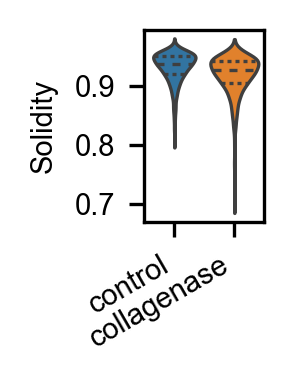

In [13]:
output_prefix = '210220-SMG-collagenase-F-actin-60x'
output_file_name = '../jupyter_figures/' + output_prefix + '-solidity.svg'

fig = plt.figure(figsize=(0.5, 0.8), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='groups', y='solidity', data=df, inner='quartile',
               scale= 'count', cut=0, linewidth=.8)

# Remove excessive clipping
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")
    
plt.xlabel(None)
plt.ylabel('Solidity')
# plt.yticks([0, 0.5, 1])

plt.savefig(output_file_name)


In [14]:
col = 'circularity'

mean_control = df_control[col].mean()
mean_collagenase = df_collagenase[col].mean()
rel_diff = (mean_collagenase - mean_control) / mean_control
print('For', col, 'the relative difference is:', rel_diff)

ttest_ind(df_control[col], df_collagenase[col])

For circularity the relative difference is: -0.05251239985390296


Ttest_indResult(statistic=12.846459408220223, pvalue=5.594790872618592e-37)

In [15]:
col = 'area'

mean_control = df_control[col].mean()
mean_collagenase = df_collagenase[col].mean()
rel_diff = (mean_collagenase - mean_control) / mean_control
print('For', col, 'the relative difference is:', rel_diff)

ttest_ind(df_control[col], df_collagenase[col])

For area the relative difference is: 0.07518150108816758


Ttest_indResult(statistic=-4.960864789773602, pvalue=7.33698260377593e-07)

In [16]:
col = 'aspect_ratio'

mean_control = df_control[col].mean()
mean_collagenase = df_collagenase[col].mean()
rel_diff = (mean_collagenase - mean_control) / mean_control
print('For', col, 'the relative difference is:', rel_diff)

ttest_ind(df_control[col], df_collagenase[col])

For aspect_ratio the relative difference is: 0.045237509351259426


Ttest_indResult(statistic=-4.268185249528357, pvalue=2.020603219410537e-05)

In [17]:
col = 'solidity'

mean_control = df_control[col].mean()
mean_collagenase = df_collagenase[col].mean()
rel_diff = (mean_collagenase - mean_control) / mean_control
print('For', col, 'the relative difference is:', rel_diff)

ttest_ind(df_control[col], df_collagenase[col])

For solidity the relative difference is: -0.013358802520025997


Ttest_indResult(statistic=12.683653438326647, pvalue=4.141353480816283e-36)

In [18]:
df.groupby('groups').describe()

cell_id                                                          \
              count        mean         std  min   25%    50%    75%    max   
groups                                                                        
collagenase  1950.0  167.475385  101.269663  1.0  82.0  163.0  244.0  394.0   
control      1715.0  126.797085   77.287811  1.0  62.0  123.0  184.0  326.0   

            centroid_x              ...  solidity            \
                 count        mean  ...       75%       max   
groups                              ...                       
collagenase     1950.0  542.194872  ...  0.941765  0.979344   
control         1715.0  437.237318  ...  0.950487  0.980609   

            area_100_sq_microns                                          \
                          count      mean       std       min       25%   
groups                                                                    
collagenase              1950.0  0.544711  0.250131  0.081324  0.374275   
control                  1715.0  0.506622  0.209310  0.076175  0.352871   

                                           
                  50%       75%       max  
groups                                     
collagenase  0.500714  0.659554  2.621479  
control      0.485372  0.636541  1.371357  

[2 rows x 72 columns]